In [1]:
#@title Installations
# %%capture
!pip install nilearn

In [2]:
#@title Imports
# %%capture
import numpy as np
import nibabel as nib
import pickle
import itertools
from nilearn import plotting
from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler

In [3]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
    fmri_dir = './participants_data_v2021'
    track = "full_track"
    results_dir = '/content/'
    track_dir = os.path.join(fmri_dir, track)
    sub_fmri_dir = os.path.join(track_dir, sub)
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB")
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
    brain_mask = '/content/example.nii'
    nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
    saveasnii(brain_mask,nii_save_path,visual_mask_3D)
    plotting.plot_glass_brain(nii_save_path,
                            title='fMRI response',plot_abs=False,
                            display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def get_fmri_all_trials(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data["train"], voxel_mask

    return ROI_data["train"]

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [11]:
#@title Functions to estimate reliability of voxels
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    covariance = covariance / (x.shape[dim])

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = covariance / (x_std * y_std)

    return corr.ravel()


def get_splithalf_reliability(fmri_all_trials):
    # number of repetitions
    num_reps =  fmri_all_trials.shape[1]
    possible_inds = range(num_reps)

    # split size defined by L
    L = int(num_reps/2)
    splits_a = []

    # This for loop generates all possible ways of selecting
    # num_reps/2 indices from num_reps (=3 here)
    for subset in itertools.combinations(possible_inds, L):
        splits_a.append(np.array(subset))

    # Number of unique splits
    splits_a = splits_a[:len(splits_a)//2+1]

    # initialing rho which will store split-half correlation for all voxels
    rho = np.zeros(fmri_all_trials.shape[2])

    ## Calculating the correlation between two splits and
    ## then averaging to get noise_ceiling
    for split_a in tqdm(splits_a):
        split_b = np.delete(possible_inds, split_a)
        a = fmri_all_trials[:,split_a,:]
        b = fmri_all_trials[:,split_b,:]
        a = np.mean(a,axis=1)
        b = np.mean(b,axis=1)
        temp_corr = vectorized_correlation(a, b)
        rho += temp_corr
    rho = rho/len(splits_a)

    # Spearman - brown reliability definition from Wikipedia https://en.wikipedia.org/wiki/Spearman%E2%80%93Brown_prediction_formula
    reliability = 2*rho/(1+rho)
    return reliability

def visualize_reliability(reliability,voxel_mask):
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1]= reliability
    brain_mask = './example.nii'
    nii_save_path =  os.path.join('/content/reliability.nii')
    saveasnii(brain_mask,nii_save_path,visual_mask_3D)
    plotting.plot_glass_brain(nii_save_path,
                            title='Voxel reliability (Training)',plot_abs=False,
                            display_mode='lyr',colorbar=True)

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


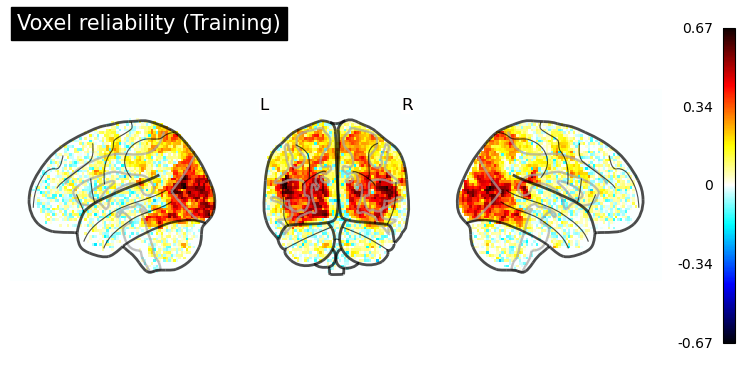

In [12]:
sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
ROI = "WB"

####### setting up paths to fMRI directory for given subject and ROI ######
fmri_dir = './participants_data_v2021'
if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
track_dir = os.path.join(fmri_dir, track)
sub_fmri_dir = os.path.join(track_dir, sub)
####### setting up paths to fMRI directory for given subject and ROI ######

# Wrapper to load fMRI data
fmri_train_alltrials,voxel_mask = get_fmri_all_trials(sub_fmri_dir, ROI)

# Calculate split-half reliability using training data
reliability = get_splithalf_reliability(fmri_train_alltrials)

# Reliability visualization
visualize_reliability(reliability,voxel_mask)